# Classificazione immagini

In [1]:
import numpy as np
import albumentations as A
from PIL import Image
import os

import matplotlib.pyplot as plt

import tensorflow as tf

from torch.utils.data import IterableDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import keras
import keras.callbacks as callbacks
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, UpSampling2D, GlobalMaxPooling2D
from keras.models import Sequential

In [ ]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


# Dataset

prima di tutto definiamo in automatico le classi tramite il nome delle cartelle

In [ ]:
cartella_data = "data"
val_folder = "test"
batch_size = 4
augmentation = True
dimensione_output = (512,512)

# salvo il nome delle classi in una lista
class_names = os.listdir(cartella_data)
class_names.sort() # ordino la lista in ordine alfabetico

print("le classi sono: ", class_names)
print("numero di classi: ", len(class_names))

le classi sono:  ['biscotti', 'caffè', 'cavallo', 'modella', 'pizza']
numero di classi:  5


ora visualizziamo lo sbilanciamento delle classi

In [ ]:
# creo un dizionario con le classi e il numero di immagini per classe
classi = {}
for i, classe in enumerate(class_names):
    classi[classe] = i

lista_immagini = []
for classe in classi.keys():
    lista_immagini += [os.path.join(cartella_data, classe, immagine) for immagine in os.listdir(os.path.join(cartella_data, classe))]
numero_immagini = len(lista_immagini)

if lista_immagini == []:
    raise Exception("Non ci sono immagini nella cartella data")

# creo un dizionario con il numero di immagini e la relativa classe
numero_immagini_per_classe = {}
for classe in classi.keys():
    numero_immagini_per_classe[classe] = len(os.listdir(os.path.join(cartella_data, classe)))

# creo un dizionario per pesare le classi in base al numero di immagini
pesi_classi = {}
for classe in classi.keys():
    pesi_classi[classe] = numero_immagini/numero_immagini_per_classe[classe]
print("pesi classi: ", pesi_classi)

# creo un dizionario con il codice della classe e il peso
pesi = {}
for classe in classi.keys():
    pesi[classi[classe]] = pesi_classi[classe]
#normalizzo i pesi in modo che il peso della classe con più immagini sia 1
pesi = {k: v / max(pesi.values()) for k, v in pesi.items()}

print("pesi: ", pesi)

# stampo il numero di immagini per classe, e la relativa percentuale
for classe in class_names:
    print("classe: ", classe, "\nnumero immagini: ", numero_immagini_per_classe[classe], "\npercentuale: ", "%.2f" % (numero_immagini_per_classe[classe]/numero_immagini*100), "%\n")

print("classi: ", classi)
print("esempio di immagine: ",lista_immagini[0])

pesi classi:  {'biscotti': 7.363636363636363, 'caffè': 3.24, 'cavallo': 6.230769230769231, 'modella': 5.4, 'pizza': 4.764705882352941}
pesi:  {0: 1.0, 1: 0.44000000000000006, 2: 0.8461538461538461, 3: 0.7333333333333334, 4: 0.6470588235294118}
classe:  biscotti 
numero immagini:  11 
percentuale:  13.58 %

classe:  caffè 
numero immagini:  25 
percentuale:  30.86 %

classe:  cavallo 
numero immagini:  13 
percentuale:  16.05 %

classe:  modella 
numero immagini:  15 
percentuale:  18.52 %

classe:  pizza 
numero immagini:  17 
percentuale:  20.99 %

classi:  {'biscotti': 0, 'caffè': 1, 'cavallo': 2, 'modella': 3, 'pizza': 4}
esempio di immagine:  data\biscotti\biscotti1.jpeg


## Generatore

In [ ]:
def generatore_batch_classification(cartella = "data", batch_size = 16, dimensione_output = (256,256),  augmentation = True):
    '''
    Generatore che restituisce un batch di immagini e le rispettive label

    Parametri
    ----------
    cartella_data : string
        path della cartella contenente le immagini
    batch_size : int
        dimensione del batch di immagini che vogliamo ottenere
    augmentation : bool
        se True, applica data augmentation alle immagini
    
    Yields
    ------
    camera_batch : numpy array
        batch di immagini della camera
    classi_batch : numpy array
        batch di classi corrispondenti alle immagini
    '''
    buffer = batch_size
    #________________
    # PREPARAZIONE
    #________________
    dict_classi = {}
    for i,classe in enumerate(os.listdir(cartella)):
        dict_classi[classe] = i

    # creo una lista con la path relativa di ogni immagine
    lista_immagini = []
    for classe in dict_classi.keys():
        lista_immagini += [os.path.join(cartella, classe, immagine) for immagine in os.listdir(os.path.join(cartella, classe))]
    num_immagini = len(lista_immagini)

    if augmentation:
        #shuffle della lista
        np.random.shuffle(lista_immagini)




    #_______________________
    # GENERAZIONE BATCH
    #_______________________
    for batch in range(0, int(num_immagini), buffer):

        #gestisco il caso in cui l'ultimo batch non sia completo
        if batch + buffer > num_immagini:
            batch = num_immagini - buffer
        
        #inizializzo i batch
        batch_immagini = []
        batch_label = []

        #ciclo che scorre le immagini del batch
        for j in range(batch, batch + buffer):

            #apro l'immagine
            with Image.open(lista_immagini[j]) as immagine:
                immagine = np.array(immagine)
            

            #----------------------------------------------
            # LAVORO SULL'IMMAGINE
            immagine = A.Resize(dimensione_output[0], dimensione_output[1])(image = immagine)["image"]
            #rimuovo il canale alpha se presente
            if immagine.shape[2] == 4:
                immagine = immagine[:,:,:3]

            if augmentation:
                trasformazione = A.Compose([
                    A.HorizontalFlip(p = 0.5),
                    A.VerticalFlip(p = 0.5),
                    A.RandomBrightnessContrast(p = 0.3),
                    A.ShiftScaleRotate(p = 0.8, rotate_limit=90),
                    A.GaussNoise(p = 0.5),
                    A.Blur(p = 0.1),
                    A.HueSaturationValue(p = 0.5),
                    A.RGBShift(p = 0.7),
                    A.RandomGamma(p = 0.3),
                    A.ChannelShuffle(p = 0.2)
                ])
                immagine = trasformazione(image = immagine)["image"]

            immagine = immagine/255  #normalizzo l'immagine
            #----------------------------------------------
            
            #se la label è presente nel nome dell'immagine, la estraggo
            for classe in dict_classi.keys():
                if classe in lista_immagini[j]:
                    label = classe
                    break        

            #assegno l'id numerico alla label
            label = dict_classi[label]

            classe_immagine = np.zeros(len(dict_classi))
            classe_immagine[label] = 1

            immagine = np.array(immagine)
            classe_immagine = np.array(classe_immagine)
            
            batch_immagini.append(immagine)
            batch_label.append(classe_immagine)

        yield np.array(batch_immagini), np.array(batch_label)

Test generatore

dimensione del batch:  (16, 256, 256, 3)
dimensione del batch:  (16, 5)
________________________
esempio di immagine: 


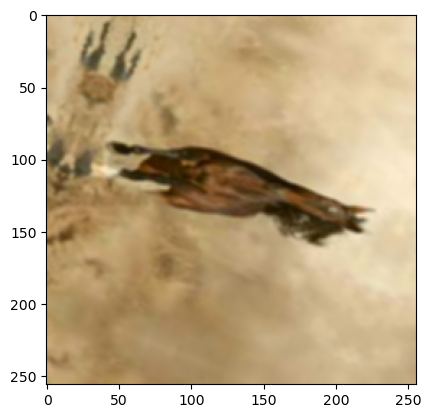

relativa label:  [0. 0. 1. 0. 0.]
label decodificata:  cavallo
________________________
________________________
valore minimo:  0.0
valore massimo:  1.0


In [ ]:
for camera_batch, classi_batch in generatore_batch_classification(cartella = "data", batch_size = 16, dimensione_output = (256,256), augmentation = True):
    print("dimensione del batch: ", camera_batch.shape)
    print("dimensione del batch: ", classi_batch.shape)
    print("________________________")
    print("esempio di immagine: ")
    plt.imshow(camera_batch[0])
    plt.show()
    print("relativa label: ", classi_batch[0])
    print("label decodificata: ", class_names[np.argmax(classi_batch[0])])
    print("________________________")
    print("________________________")
    print("valore minimo: ", np.min(camera_batch[0]))
    print("valore massimo: ", np.max(camera_batch[0]))
    break
    

## Datasets

In [ ]:
# train: 80%
# validation: 10%
# test: 10%
#augmentation = False

trainset = tf.data.Dataset.from_generator(
    generatore_batch_classification,
    args=(cartella_data, batch_size, dimensione_output, augmentation),
    output_signature=(
        tf.TensorSpec(shape=(batch_size, dimensione_output[0], dimensione_output[1], 3)),  # Immagine della camera
        tf.TensorSpec(shape=(batch_size, len(class_names))),  #label
    )
)

valset = tf.data.Dataset.from_generator(
    generatore_batch_classification,
    args=(val_folder, batch_size, dimensione_output, True),
    output_signature=(
        tf.TensorSpec(shape=(batch_size, dimensione_output[0], dimensione_output[1], 3)),  # Immagine della camera
        tf.TensorSpec(shape=(batch_size, len(class_names))),  #label
    )
)

# test del trainset
for camera_batch, classi_batch in trainset.take(1):
    print("camera batch train: ", camera_batch.shape)
    print("label batch train: ", classi_batch.shape)

# test del valset
for camera_batch, classi_batch in valset.take(1):
    print("camera batch val: ", camera_batch.shape)
    print("label batch val: ", classi_batch.shape)

camera batch train:  (4, 512, 512, 3)
label batch train:  (4, 5)
camera batch val:  (4, 512, 512, 3)
label batch val:  (4, 5)


In [ ]:
# # split del dataset
# dimensione_dataset = numero_immagini//batch_size
# train_size = int(0.9 * dimensione_dataset)
# val_size = int(0.1 * dimensione_dataset)
# #test_size = int(0.1 * dimensione_dataset)

# immagini_utilizzate = train_size + val_size# + test_size
# if immagini_utilizzate < dimensione_dataset:
#     train_size += dimensione_dataset - immagini_utilizzate

# trainset = dataset.take(train_size)
# #testset = dataset.skip(train_size)
# valset = dataset.skip(train_size)#+test_size)

# print("numero di batch di train: ", train_size)
# print("numero di batch di validation: ", val_size)
# #print("numero di batch di test: ", test_size)

dimensione del batch:  (4, 512, 512, 3)
dimensione del batch:  (4, 5)


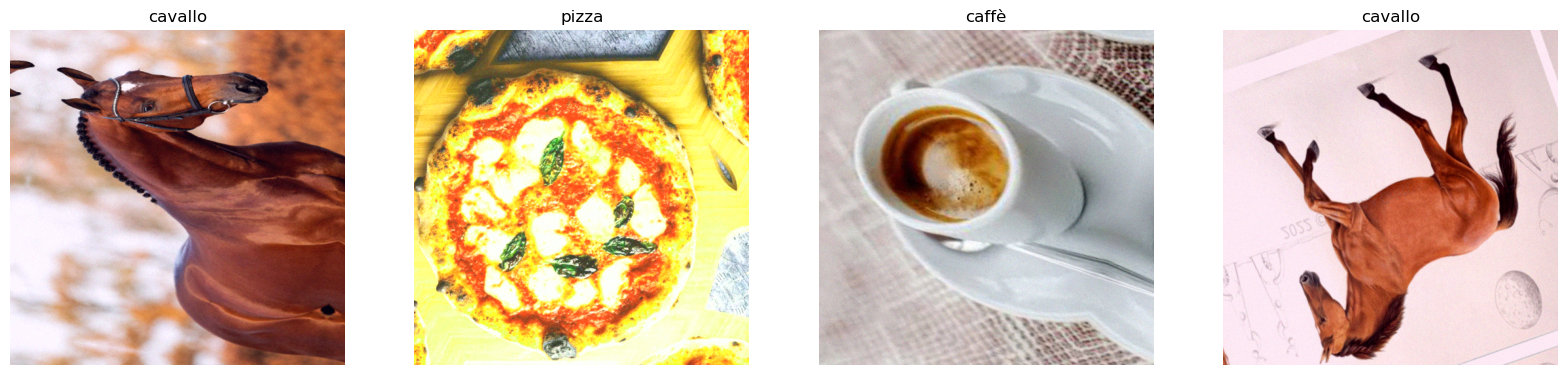

In [ ]:
# test del dataset
for camera_batch, classi_batch in valset:
    print("dimensione del batch: ", camera_batch.shape)
    print("dimensione del batch: ", classi_batch.shape)
    # grafico che contiene tutte le immagini del batch
    plt.figure(figsize=(20,20))
    for i in range(batch_size):
        plt.subplot(4,4,i+1)
        plt.imshow(camera_batch[i])
        plt.title(class_names[np.argmax(classi_batch[i])])
        plt.axis('off')
    break

## Callbacks

In [ ]:
callbacks_list = [
    callbacks.ModelCheckpoint(
        filepath='./models/model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss',
        save_best_only=True
    ),

    callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0001,
        patience=20,
        restore_best_weights=True,
    ),

    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=20
    )
]

# Modelli

## Sequential

In [ ]:
with strategy.scope():
    modello_convoluzionale = Sequential([
            #Resizing(256, 256, interpolation="nearest"),
            # downpart
            Conv2D(64, 3, padding='same', activation='relu'),
            Conv2D(64, 3, padding='same', activation='relu'),
            MaxPooling2D(),
            Conv2D(128, 3, padding='same', activation='relu'),
            Conv2D(128, 3, padding='same', activation='relu'),
            MaxPooling2D(),
            Conv2D(256, 3, padding='same', activation='relu'),
            MaxPooling2D(),
            # uppart
            UpSampling2D(),
            Conv2D(256, 3, padding='same', activation='relu'),
            UpSampling2D(),
            Conv2D(128, 3, padding='same', activation='relu'),
            Conv2D(128, 3, padding='same', activation='relu'),
            UpSampling2D(),
            Conv2D(64, 3, padding='same', activation='relu'),
            Conv2D(64, 3, padding='same', activation='relu'),
            UpSampling2D(),
            Flatten(),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(len(class_names), activation='softmax'),  # lo strato dense con il n definisce il numero di neuroni, devono essere n_classi perchè abbiamo n_classi classi, e ritorna 1 valore per ogni classe nella terza dimensione delle label
            # siccome devo riestituire una singola label devo modificare l'output del modello da (batch_size, 256, 256,  n_classi) a (batch_size, n_classi)
            # per fare ciò uso un layer globale di pooling che mi restituisce un valore per ogni classe
            #GlobalAveragePooling2D() # questo layer mi restituisce un valore per ogni classe
            GlobalMaxPooling2D()
        ])

In [ ]:
with strategy.scope():
    modello_convoluzionale.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy(), metrics=[keras.metrics.F1Score()])
    modello_convoluzionale.build(input_shape=(None,dimensione_output[0],dimensione_output[1],3))
    modello_convoluzionale.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 256, 256, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 128, 128, 128)     0         
 g2D)                                                  

In [ ]:
with strategy.scope():
    modello_convoluzionale.fit(x=trainset, epochs=1, validation_data=valset, initial_epoch=0, class_weight=pesi)

dimensione del batch:  (4, 512, 512, 3)
dimensione del batch:  (4, 5)
------------------------
#######################
Immagine numero:  0


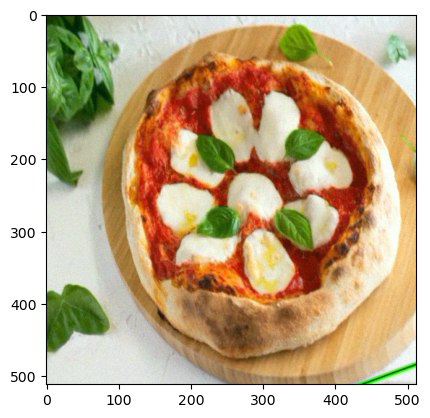

true label:  tf.Tensor([0. 0. 0. 0. 1.], shape=(5,), dtype=float32)
decodified:  pizza
________________________
PREDICT: 
________________________
1/1 [==============================] - 2s 2s/step
PREDICTED LABEL:  modella
PROBABILITIES:  {'biscotti': 0.20130137, 'caffè': 0.20043686, 'cavallo': 0.20081714, 'modella': 0.20287919, 'pizza': 0.20022367}
#######################
#######################
Immagine numero:  1


true label:  tf.Tensor([0. 0. 0. 0. 1.], shape=(5,), dtype=float32)
decodified:  pizza
________________________
PREDICT: 
________________________
1/1 [==============================] - 2s 2s/step
PREDICTED LABEL:  modella
PROBABILITIES:  {'biscotti': 0.20123181, 'caffè': 0.20052657, 'cavallo': 0.20086782, 'modella': 0.20302425, 'pizza': 0.20022097}
#######################
#######################
Immagine numero:  2


true label:  tf.Tensor([0. 0. 0. 0. 1.], shape=(5,), dtype=float32)
decodified:  pizza
________________________
PREDICT: 
________________________
1/1 [==============================] - 2s 2s/step
PREDICTED LABEL:  modella
PROBABILITIES:  {'biscotti': 0.20128292, 'caffè': 0.20041066, 'cavallo': 0.20076084, 'modella': 0.20301484, 'pizza': 0.20003052}
#######################
#######################
Immagine numero:  3


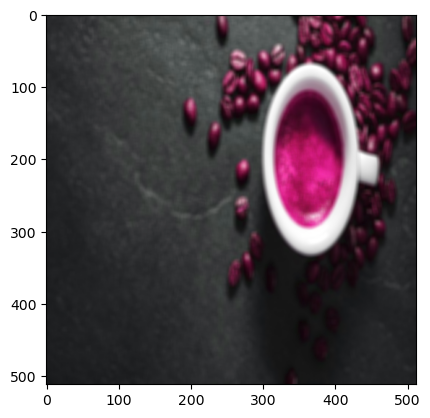

true label:  tf.Tensor([0. 1. 0. 0. 0.], shape=(5,), dtype=float32)
decodified:  caffè
________________________
PREDICT: 
________________________
1/1 [==============================] - 2s 2s/step
PREDICTED LABEL:  modella
PROBABILITIES:  {'biscotti': 0.2010539, 'caffè': 0.20010881, 'cavallo': 0.20036721, 'modella': 0.20242448, 'pizza': 0.20002316}
#######################


In [ ]:
# test del modello
for camera_batch, classi_batch in valset.take(1):
    print("dimensione del batch: ", camera_batch.shape)
    print("dimensione del batch: ", classi_batch.shape)
    print("------------------------")
    for i,immagine in enumerate(camera_batch):
        print("#######################")
        print("Immagine numero: ", i)
        plt.imshow(immagine)
        plt.show()
        print("true label: ", classi_batch[i])
        print("decodified: ", class_names[np.argmax(classi_batch[i])])
        print("________________________")
        print("PREDICT: ")
        print("________________________")
        previsone = modello_convoluzionale.predict(np.array([immagine]))
        probabilità_per_classe = {}
        for i, classe in enumerate(class_names):
            probabilità_per_classe[classe] = previsone[0][i]
        print("PREDICTED LABEL: ", class_names[np.argmax(previsone[0])])
        print("PROBABILITIES: ", probabilità_per_classe)
        print("#######################")

## RES-NET

In [ ]:
n_classi = len(class_names)
class ResBlock(keras.Model):
    def __init__(self,num_hidden):
        super().__init__()
        self.conv1 = keras.layers.Conv2D(num_hidden, kernel_size = 3, padding = "same")
        self.bn1 = keras.layers.BatchNormalization()
        self.conv2 = keras.layers.Conv2D(num_hidden, kernel_size = 3, padding = "same")
        self.bn2 = keras.layers.BatchNormalization()
        
    def call(self, x):
        residui = x
        x = tf.nn.relu(self.bn1(self.conv1(x))) #il valore di input del "blocco" passa per "conv1", il suo output passa per bn1 (normalizza il batch, ossia li porta tra 0 e 1) e infine passa per la relu
        x = self.bn2(self.conv2(x))
        x += residui # questa è la skip connection (sommiamo l'input con l'output del blocco) # quindi l'insieme di filtri (batch x dimensione x dimensione x dim filtri)
        return tf.nn.relu(x)

    
class ResNet(keras.Model):
    def __init__(self, n_blocchi, n_hidden):
        super().__init__()
        self.start_block = keras.Sequential([
            keras.layers.Conv2D(n_hidden, kernel_size = 3, padding = "same"),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU()])
        self.back_bone = [ResBlock(n_hidden) for _ in range(n_blocchi)] # l'insieme di tutti i ResBlock
        self.fine = keras.Sequential([
            keras.layers.Flatten(),
            keras.layers.Dense(n_hidden, activation='relu'),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(len(class_names), activation='softmax')]) # output della rete
    
    def call(self, x):
        x = self.start_block(x)
        for resblock in self.back_bone:
            x = resblock(x)
        risultato_rete = self.fine(x)
    
        return risultato_rete

In [ ]:
with strategy.scope():
    model_resnet = ResNet(n_blocchi = 10, n_hidden = 32)

In [ ]:
with strategy.scope():
    model_resnet.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy(), metrics=[keras.metrics.F1Score()])
    model_resnet.build(input_shape=(None,dimensione_output[0],dimensione_output[1],3))
    model_resnet.summary()


Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 512, 512, 64)      2048      
                                                                 
 res_block (ResBlock)        multiple                  74368     
                                                                 
 res_block_1 (ResBlock)      multiple                  74368     
                                                                 
 res_block_2 (ResBlock)      multiple                  74368     
                                                                 
 res_block_3 (ResBlock)      multiple                  74368     
                                                                 
 res_block_4 (ResBlock)      multiple                  74368     
                                                                 
 sequential_2 (Sequential)   (None, 5)                 107

c:\Users\Gabriele Laguna\anaconda3\Lib\site-packages\keras\src\utils\layer_utils.py:146: RuntimeWarning: overflow encountered in scalar multiply
  total_memory_size += weight_shape * per_param_size


In [ ]:
with strategy.scope():
    model_resnet.fit(x=trainset, epochs=1, validation_data=valset, initial_epoch=0, class_weight=pesi)

In [ ]:
# test del modello
for camera_batch, classi_batch in valset.take(1):
    print("dimensione del batch: ", camera_batch.shape)
    print("dimensione del batch: ", classi_batch.shape)
    print("------------------------")
    for i,immagine in enumerate(camera_batch):
        print("#######################")
        print("Immagine numero: ", i)
        plt.imshow(immagine)
        plt.show()
        print("true label: ", classi_batch[i])
        print("decodified: ", class_names[np.argmax(classi_batch[i])])
        print("________________________")
        print("PREDICT: ")
        print("________________________")
        previsone = model_resnet.predict(np.array([immagine]))
        probabilità_per_classe = {}
        for i, classe in enumerate(class_names):
            probabilità_per_classe[classe] = previsone[0][i]
        print("PREDICTED LABEL: ", class_names[np.argmax(previsone[0])])
        print("PROBABILITIES: ", probabilità_per_classe)
        print("#######################")

dimensione del batch:  (4, 512, 512, 3)
dimensione del batch:  (4, 5)
------------------------
#######################
Immagine numero:  0


true label:  tf.Tensor([0. 0. 0. 0. 1.], shape=(5,), dtype=float32)
decodified:  pizza
________________________
PREDICT: 
________________________
1/1 [==============================] - 3s 3s/step
PREDICTED LABEL:  pizza
PROBABILITIES:  {'biscotti': 0.23157947, 'caffè': 0.23680767, 'cavallo': 0.24896123, 'modella': 0.2289952, 'pizza': 0.2507192}
#######################
#######################
Immagine numero:  1


true label:  tf.Tensor([0. 1. 0. 0. 0.], shape=(5,), dtype=float32)
decodified:  caffè
________________________
PREDICT: 
________________________
1/1 [==============================] - 2s 2s/step
PREDICTED LABEL:  cavallo
PROBABILITIES:  {'biscotti': 0.21149293, 'caffè': 0.23518944, 'cavallo': 0.23525754, 'modella': 0.22488722, 'pizza': 0.22624756}
#######################
#######################
Immagine numero:  2


true label:  tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float32)
decodified:  biscotti
________________________
PREDICT: 
________________________
1/1 [==============================] - 2s 2s/step
PREDICTED LABEL:  cavallo
PROBABILITIES:  {'biscotti': 0.23086217, 'caffè': 0.25117823, 'cavallo': 0.25630108, 'modella': 0.239197, 'pizza': 0.2434102}
#######################
#######################
Immagine numero:  3


true label:  tf.Tensor([0. 0. 1. 0. 0.], shape=(5,), dtype=float32)
decodified:  cavallo
________________________
PREDICT: 
________________________
1/1 [==============================] - 2s 2s/step
PREDICTED LABEL:  caffè
PROBABILITIES:  {'biscotti': 0.21975689, 'caffè': 0.28051776, 'cavallo': 0.2612932, 'modella': 0.25081685, 'pizza': 0.24134918}
#######################


## Fine Tuning RES-NET50

In [ ]:
from keras.applications.resnet_v2 import ResNet50V2
from keras.models import Model

In [ ]:
with strategy.scope():
    resnet = ResNet50V2(include_top=False, weights='imagenet', input_shape=(dimensione_output[0],dimensione_output[1],3))
    resnet.trainable = False

    x = Flatten()(resnet.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(len(class_names), activation='softmax')(x)

In [ ]:
with strategy.scope():
    resnet_fine_tuning = Model(inputs=resnet.input, outputs=x)

In [ ]:
with strategy.scope():
    resnet_fine_tuning.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy(), metrics=[keras.metrics.F1Score()])
    resnet_fine_tuning.build(input_shape=(None,dimensione_output[0],dimensione_output[1],3))
    resnet_fine_tuning.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 256, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 258, 258, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

 conv2_block1_out (Add)      (None, 128, 128, 256)        0         ['conv2_block1_0_conv[0][0]', 
                                                                     'conv2_block1_3_conv[0][0]'] 
                                                                                                  
 conv2_block2_preact_bn (Ba  (None, 128, 128, 256)        1024      ['conv2_block1_out[0][0]']    
 tchNormalization)                                                                                
                                                                                                  
 conv2_block2_preact_relu (  (None, 128, 128, 256)        0         ['conv2_block2_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv2_block2_1_conv (Conv2  (None, 128, 128, 64)         16384     ['conv2_block2_preact_relu[0][
 D)       

In [ ]:
resnet_fine_tuning.load_weights("resnet_fine_tuning.keras")

In [ ]:
with strategy.scope():
    resnet_fine_tuning.fit(x=trainset, epochs=7, validation_data=valset, initial_epoch=5, class_weight=pesi)

Epoch 1/5

21/21 [==============================] - 134s 6s/step - loss: 22.7665 - f1_score: 0.6222 - val_loss: 13.7827 - val_f1_score: 0.8357
Epoch 2/5
21/21 [==============================] - 117s 6s/step - loss: 9.3866 - f1_score: 0.8329 - val_loss: 8.9509 - val_f1_score: 0.8247
Epoch 3/5
21/21 [==============================] - 128s 6s/step - loss: 6.4090 - f1_score: 0.9251 - val_loss: 10.9385 - val_f1_score: 0.9092
Epoch 4/5
21/21 [==============================] - 111s 5s/step - loss: 1.7947 - f1_score: 0.9591 - val_loss: 3.1922 - val_f1_score: 0.9156
Epoch 5/5
21/21 [==============================] - 110s 5s/step - loss: 4.6998 - f1_score: 0.9514 - val_loss: 2.9726 - val_f1_score: 0.9169


In [ ]:
# salvo il modello
resnet_fine_tuning.save("resnet_fine_tuning.keras")

dimensione del batch:  (4, 512, 512, 3)
dimensione del batch:  (4, 5)
------------------------
#######################
Immagine numero:  0


true label:  tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float32)
decodified:  biscotti
________________________
PREDICT: 
________________________
1/1 [==============================] - 4s 4s/step
PREDICTED LABEL:  biscotti
PROBABILITIES:  {'biscotti': 1.0, 'caffè': 0.0, 'cavallo': 0.0, 'modella': 0.0, 'pizza': 0.0}
#######################
#######################
Immagine numero:  1


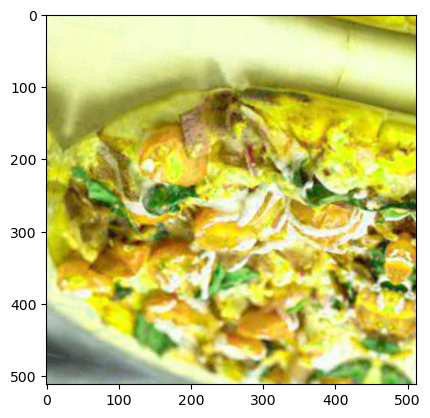

true label:  tf.Tensor([0. 0. 0. 0. 1.], shape=(5,), dtype=float32)
decodified:  pizza
________________________
PREDICT: 
________________________
1/1 [==============================] - 1s 597ms/step
PREDICTED LABEL:  pizza
PROBABILITIES:  {'biscotti': 0.0, 'caffè': 0.0, 'cavallo': 0.0, 'modella': 0.0, 'pizza': 1.0}
#######################
#######################
Immagine numero:  2


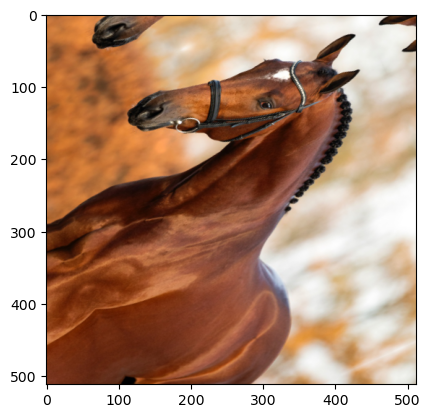

true label:  tf.Tensor([0. 0. 1. 0. 0.], shape=(5,), dtype=float32)
decodified:  cavallo
________________________
PREDICT: 
________________________
1/1 [==============================] - 1s 568ms/step
PREDICTED LABEL:  cavallo
PROBABILITIES:  {'biscotti': 0.0, 'caffè': 0.0, 'cavallo': 1.0, 'modella': 0.0, 'pizza': 0.0}
#######################
#######################
Immagine numero:  3


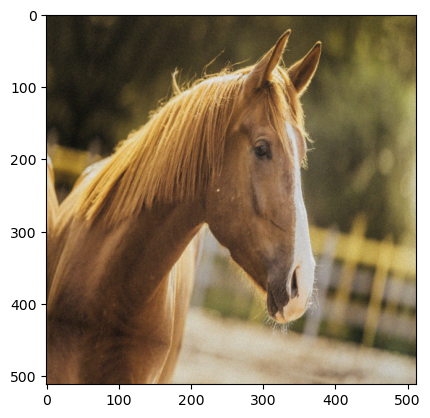

true label:  tf.Tensor([0. 0. 1. 0. 0.], shape=(5,), dtype=float32)
decodified:  cavallo
________________________
PREDICT: 
________________________
1/1 [==============================] - 1s 542ms/step
PREDICTED LABEL:  cavallo
PROBABILITIES:  {'biscotti': 0.0, 'caffè': 0.0, 'cavallo': 1.0, 'modella': 0.0, 'pizza': 0.0}
#######################


In [ ]:
# test del modello
for camera_batch, classi_batch in valset.take(1):
    print("dimensione del batch: ", camera_batch.shape)
    print("dimensione del batch: ", classi_batch.shape)
    print("------------------------")
    for i,immagine in enumerate(camera_batch):
        print("#######################")
        print("Immagine numero: ", i)
        plt.imshow(immagine)
        plt.show()
        print("true label: ", classi_batch[i])
        print("decodified: ", class_names[np.argmax(classi_batch[i])])
        print("________________________")
        print("PREDICT: ")
        print("________________________")
        previsone = resnet_fine_tuning.predict(np.array([immagine]))
        probabilità_per_classe = {}
        for i, classe in enumerate(class_names):
            probabilità_per_classe[classe] = previsone[0][i]
        print("PREDICTED LABEL: ", class_names[np.argmax(previsone[0])])
        print("PROBABILITIES: ", probabilità_per_classe)
        print("#######################")

In [ ]:
# test del modello con videocamera
import cv2
cap = cv2.VideoCapture(0)

while True:
    # acquisisco l'immagine dalla webcam
    ret, frame = cap.read()
    
    if not ret:
        break
    
    # faccio il resize dell'immagine
    frame = A.Resize(dimensione_output[0], dimensione_output[1])(image = frame)["image"]
    frame = np.array(frame)
    frame = frame/255

    predizione = resnet_fine_tuning.predict(frame)
    probabilità_per_classe = {}
    for i, classe in enumerate(class_names):
        probabilità_per_classe[classe] = previsone[0][i]

    # aggiungo la label all'immagine
    cv2.putText(frame, class_names[np.argmax(predizione[0])], (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(frame, str(probabilità_per_classe), (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # mostro l'immagine
    cv2.imshow('frame',frame)

    # se premo q esco
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    

    print(frame)

: 